In [24]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
 
%matplotlib inline
 
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

In [25]:
url = "C:\\Users\\ivonnics\\Documents\\JOSE LUIS\\Cursos Cursera\\Machine Learning\\sales3.csv"
sales_df = pd.read_csv(url, index_col='date', parse_dates=True)
#sales_df = pd.read_csv('../examples/retail_sales.csv', index_col='date', parse_dates=True)
sales_df.head()

,sales
date,
2009-10-01,338630
2009-11-01,339386
2009-12-01,400264
2010-01-01,314640
2010-02-01,311022


In [26]:
df = sales_df.reset_index()
df.head()

,date,sales
0,2009-10-01,338630
1,2009-11-01,339386
2,2009-12-01,400264
3,2010-01-01,314640
4,2010-02-01,311022


In [27]:
df=df.rename(columns={'date':'ds', 'sales':'y'})
df.head()

,ds,y
0,2009-10-01,338630
1,2009-11-01,339386
2,2009-12-01,400264
3,2010-01-01,314640
4,2010-02-01,311022


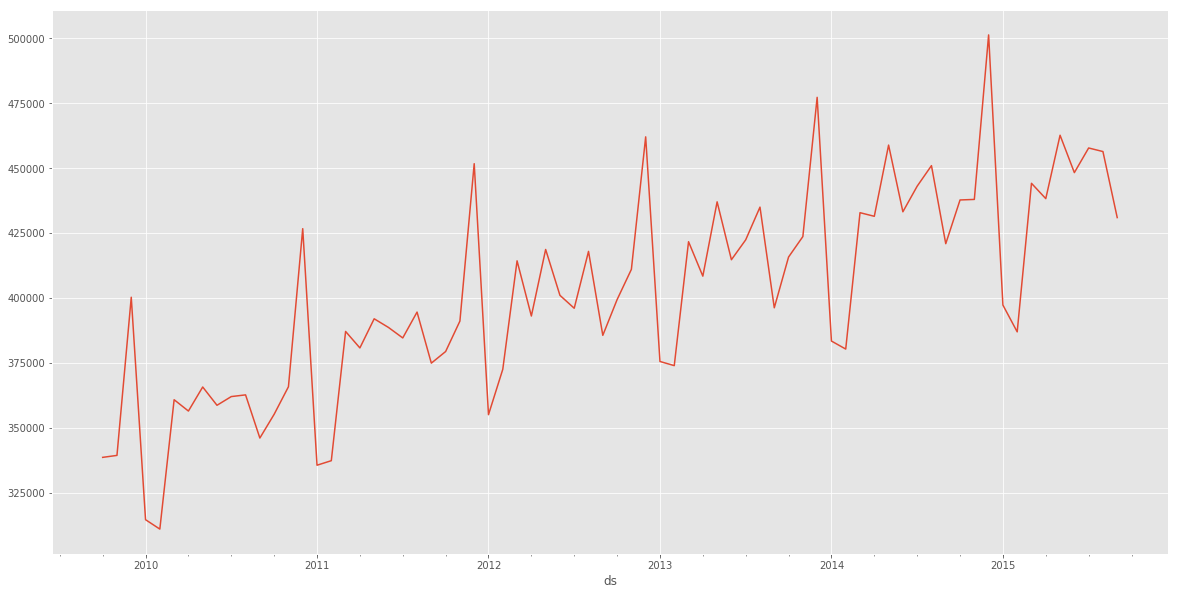

In [28]:
df.set_index('ds').y.plot()

When working with time-series data, its good to take a look at the data to determine if trends exist, whether it is stationary, has any outliers and/or any other anamolies. Facebook prophet's example uses the log-transform as a way to remove some of these anomolies but it isn't the absolute 'best' way to do this...but given that its the example and a simple data series, I'll follow their lead for now. Taking the log of a number is easily reversible to be able to see your original data.

To log-transform your data, you can use numpy's log() function

In [29]:
#Rescaling
df['y'] = np.log(df['y'])
df.tail()

,ds,y
67,2015-05-01,13.044650
68,2015-06-01,13.013060
69,2015-07-01,13.033991
70,2015-08-01,13.030993
71,2015-09-01,12.973671


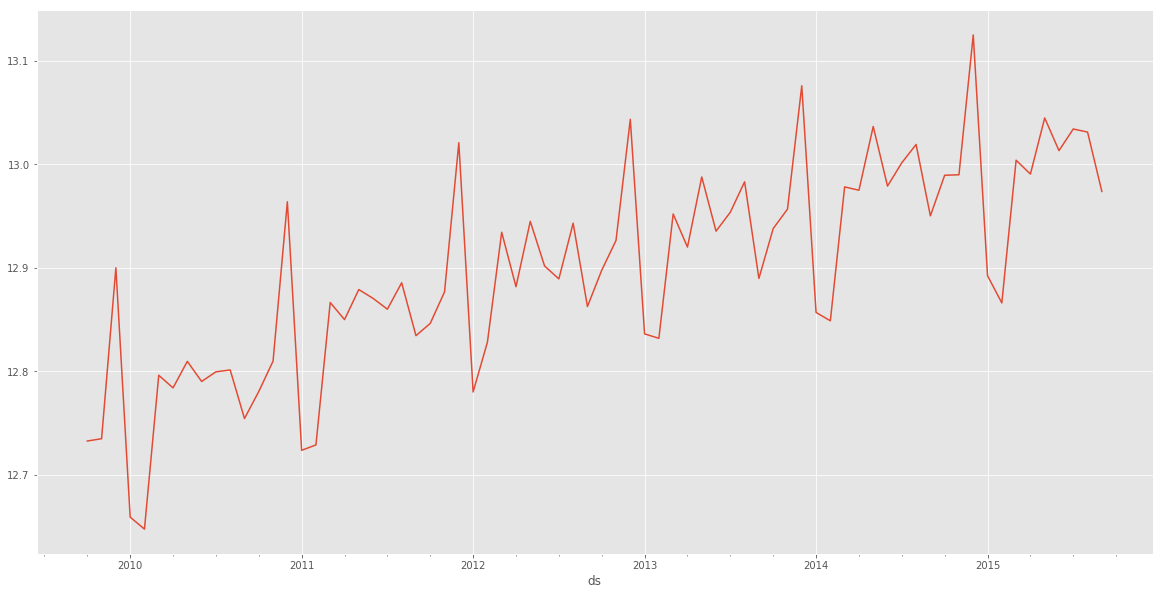

In [30]:
df.set_index('ds').y.plot()

As you can see in the above chart, the plot looks the same as the first one but just at a different scale.

## Running Prophet
Now, let's set prophet up to begin modeling our data.

Note: Since we are using monthly data, you'll see a message from Prophet saying Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this. This is OK since we are workign with monthly data but you can disable it by using weekly_seasonality=True in the instantiation of Prophet.

In [31]:
model = Prophet()
model.fit(df);

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
Forecasting is fairly useless unless you can look into the future, so we need to add some future dates to our dataframe. For this example, I want to forecast 2 years into the future, so I'll built a future dataframe with 24 periods since we are working with monthly data. Note the freq='m' inclusion to ensure we are adding 24 months of data.

This can be done with the following code:

In [32]:
future = model.make_future_dataframe(periods=24, freq = 'm')
future.tail()

,ds
91,2017-04-30
92,2017-05-31
93,2017-06-30
94,2017-07-31
95,2017-08-31


In [33]:
# To forecast this future data, we need to run it through Prophet's model.
forecast = model.predict(future)

In [34]:
# The resulting forecast dataframe contains quite a bit of data, but we really only care about a few columns. First, let's look at the full dataframe:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
91,2017-04-30,13.042369,12.871123,13.225531,12.853499,13.207039,0.020135,0.020135,0.020135,0.020135,0.020135,0.020135,0.0,0.0,0.0,13.062504
92,2017-05-31,13.044090,12.856258,13.233882,12.838054,13.220896,0.012944,0.012944,0.012944,0.012944,0.012944,0.012944,0.0,0.0,0.0,13.057035
93,2017-06-30,13.045756,12.857201,13.263626,12.827651,13.233603,0.030465,0.030465,0.030465,0.030465,0.030465,0.030465,0.0,0.0,0.0,13.076222
94,2017-07-31,13.047477,12.822856,13.256733,12.814422,13.246438,0.007391,0.007391,0.007391,0.007391,0.007391,0.007391,0.0,0.0,0.0,13.054869
95,2017-08-31,13.049199,12.779089,13.245519,12.801526,13.262487,-0.022159,-0.022159,-0.022159,-0.022159,-0.022159,-0.022159,0.0,0.0,0.0,13.027040


In [35]:
# We really only want to look at yhat, yhat_lower and yhat_upper, so we can do that with:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
91,2017-04-30,13.062504,12.871123,13.225531
92,2017-05-31,13.057035,12.856258,13.233882
93,2017-06-30,13.076222,12.857201,13.263626
94,2017-07-31,13.054869,12.822856,13.256733
95,2017-08-31,13.027040,12.779089,13.245519


## Plotting Prophet results
Prophet has a plotting mechanism called plot. This plot functionality draws the original data (black dots), the model (blue line) and the error of the forecast (shaded blue area).

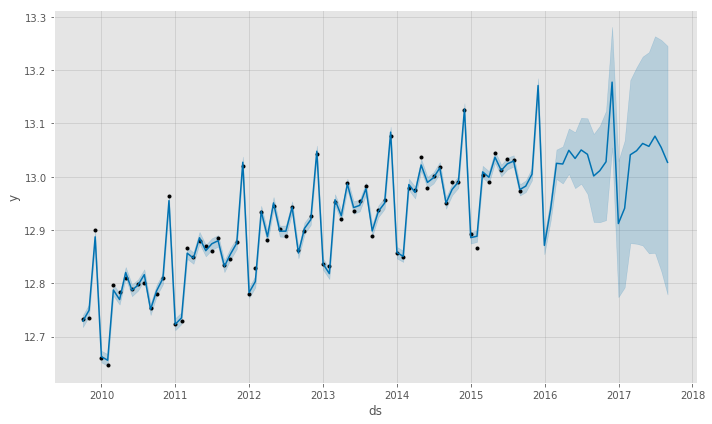

In [36]:

model.plot(forecast);

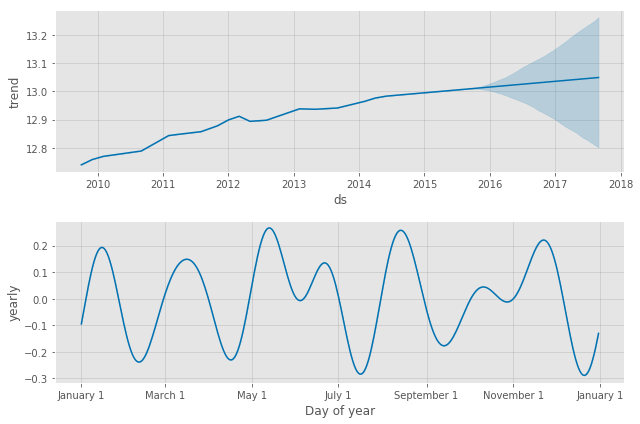

In [38]:
fig2 = model.plot_components(forecast)

## Visualizing Prophet models
In order to build a useful dataframe to visualize our model versus our original data, we need to combine the output of the Prophet model with our original data set, then we'll build a new chart manually using pandas and matplotlib.

First, let's set our dataframes to have the same index of ds

In [39]:
df.set_index('ds', inplace=True)
forecast.set_index('ds', inplace=True)

In [40]:
# Now, we'll combine the original data and our forecast model data
viz_df = sales_df.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
viz_df.head()

,sales,yhat,yhat_lower,yhat_upper
2009-10-01,338630.0,12.729047,12.717837,12.740074
2009-11-01,339386.0,12.749386,12.738085,12.760536
2009-12-01,400264.0,12.887231,12.876488,12.898074
2010-01-01,314640.0,12.662235,12.651616,12.673243
2010-02-01,311022.0,12.655712,12.645114,12.667041


If we look at the head(), we see the data has been joined correctly but the scales of our original data (sales) and our model (yhat) are different. We need to rescale the yhat colums(s) to get the same scale, so we'll use numpy's exp function to do that.

In [41]:
viz_df['yhat_rescaled'] = np.exp(viz_df['yhat'])
viz_df.head()

,sales,yhat,yhat_lower,yhat_upper,yhat_rescaled
2009-10-01,338630.0,12.729047,12.717837,12.740074,337407.478861
2009-11-01,339386.0,12.749386,12.738085,12.760536,344340.408131
2009-12-01,400264.0,12.887231,12.876488,12.898074,395233.097398
2010-01-01,314640.0,12.662235,12.651616,12.673243,315601.397904
2010-02-01,311022.0,12.655712,12.645114,12.667041,313549.181841


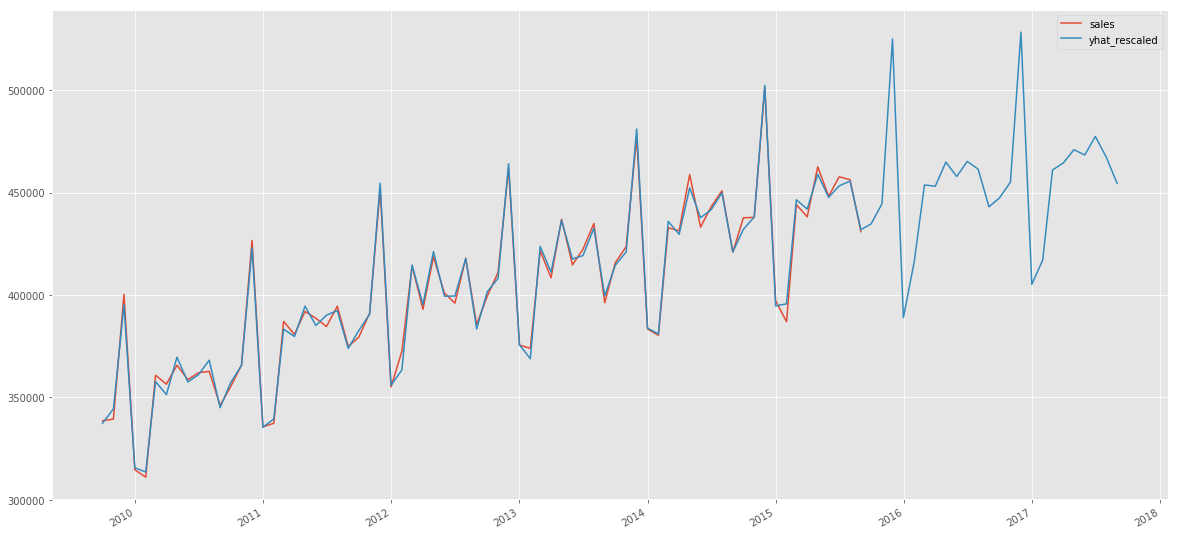

In [42]:
viz_df[['sales', 'yhat_rescaled']].plot()

You can see from the chart that the model (blue) is pretty good when plotted against the actual signal (orange) but I like to make my vizualization's a little better to understand. To build my 'better' visualization, we'll need to go back to our original sales_df and forecast dataframes.

First things first - we need to find the 2nd to last date of the original sales data in sales_df in order to ensure the original sales data and model data charts are connected.

In [43]:
sales_df.index = pd.to_datetime(sales_df.index) #make sure our index as a datetime object
connect_date = sales_df.index[-2] #select the 2nd to last date

Using the connect_date we can now grab only the model data that after that date (you'll see why in a minute). To do this, we'll mask the forecast data.

In [44]:
mask = (forecast.index > connect_date)
predict_df = forecast.loc[mask]
predict_df.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,
2015-09-01,13.008666,12.964711,12.985846,13.008666,13.008666,-0.032685,-0.032685,-0.032685,-0.032685,-0.032685,-0.032685,0.0,0.0,0.0,12.975982
2015-09-30,13.010276,12.971281,12.992952,13.009920,13.010483,-0.027821,-0.027821,-0.027821,-0.027821,-0.027821,-0.027821,0.0,0.0,0.0,12.982456
2015-10-31,13.011998,12.993477,13.016603,13.008891,13.015072,-0.007180,-0.007180,-0.007180,-0.007180,-0.007180,-0.007180,0.0,0.0,0.0,13.004817
2015-11-30,13.013663,13.156849,13.184841,13.006429,13.021182,0.157584,0.157584,0.157584,0.157584,0.157584,0.157584,0.0,0.0,0.0,13.171247
2015-12-31,13.015385,12.854417,12.887750,13.002817,13.028128,-0.144186,-0.144186,-0.144186,-0.144186,-0.144186,-0.144186,0.0,0.0,0.0,12.871198


In [45]:
# Now, let's build a dataframe to use in our new visualization. We'll follow the same steps we did before.
viz_df = sales_df.join(predict_df[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
viz_df['yhat_scaled']=np.exp(viz_df['yhat'])
# Now, if we take a look at the head() of viz_df we'll see 'NaN's everywhere except for our original data rows.
viz_df.head()

,sales,yhat,yhat_lower,yhat_upper,yhat_scaled
2009-10-01,338630.0,NaN,NaN,NaN,NaN
2009-11-01,339386.0,NaN,NaN,NaN,NaN
2009-12-01,400264.0,NaN,NaN,NaN,NaN
2010-01-01,314640.0,NaN,NaN,NaN,NaN
2010-02-01,311022.0,NaN,NaN,NaN,NaN


In [46]:
# If we take a look at the tail() of the viz_df you'll see we have data for the forecasted data and NaN's
# for the original data series.
viz_df.tail()

,sales,yhat,yhat_lower,yhat_upper,yhat_scaled
2017-04-30,NaN,13.062504,12.871123,13.225531,470948.402915
2017-05-31,NaN,13.057035,12.856258,13.233882,468379.676599
2017-06-30,NaN,13.076222,12.857201,13.263626,477453.252115
2017-07-31,NaN,13.054869,12.822856,13.256733,467366.374132
2017-08-31,NaN,13.027040,12.779089,13.245519,454539.283192


## time to plot
Now, let's plot everything to get the 'final' visualization of our sales data and forecast with errors.

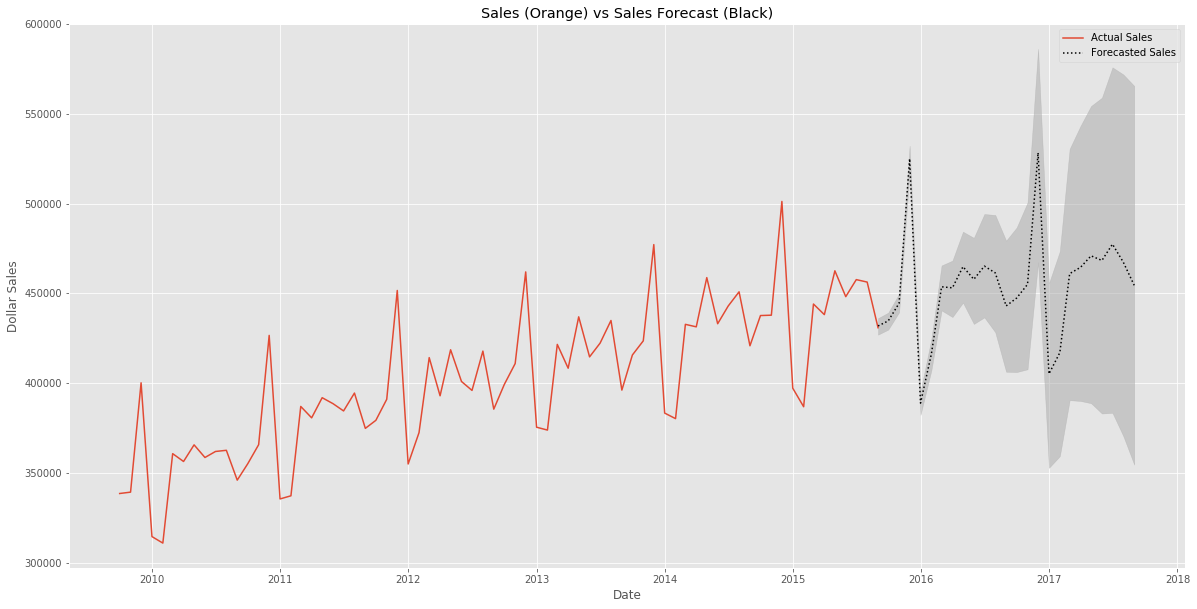

In [47]:
fig, ax1 = plt.subplots()
ax1.plot(viz_df.sales)
ax1.plot(viz_df.yhat_scaled, color='black', linestyle=':')
ax1.fill_between(viz_df.index, np.exp(viz_df['yhat_upper']), np.exp(viz_df['yhat_lower']), alpha=0.5, color='darkgray')
ax1.set_title('Sales (Orange) vs Sales Forecast (Black)')
ax1.set_ylabel('Dollar Sales')
ax1.set_xlabel('Date')

L=ax1.legend() #get the legend
L.get_texts()[0].set_text('Actual Sales') #change the legend text for 1st plot
L.get_texts()[1].set_text('Forecasted Sales') #change the legend text for 2nd plot

This visualization is much better (in my opinion) than the default fbprophet plot. It is much easier to quickly understand and describe what's happening. The orange line is actual sales data and the black dotted line is the forecast. The gray shaded area is the uncertaintity estimation of the forecast.